# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/kyledalope/Documents/GitHub/ads509-tm-sentiment"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "/Users/kyledalope/Downloads/M1 Results/twitter"
lyrics_folder = "/Users/kyledalope/Downloads/M1 Results/lyrics"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data

lyrics = {}
# For loop to the artist subfolders
for artist_sub in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist_sub)
    if os.path.isdir(artist_path):
        lyrics[artist_sub] = {}
        
        # For loop to the songs for each artist subfolder
        for song in os.listdir(artist_path):
            song_path = os.path.join(artist_path, song)
            if os.path.isfile(song_path):
                with open(song_path, 'r') as file:
                    lyrics_content = file.read()
                    lyrics[artist_sub][song] = lyrics_content

# Create a dataframe from the lyrics dictionary
lyrics_data = pd.DataFrame([(artist, song, lyrics[artist][song]) for artist in lyrics for song in lyrics[artist]],
columns=['artist', 'song', 'lyrics_content'])

In [5]:
# read in the twitter data

twitter_descriptions = {}

for file_name in os.listdir(twitter_folder):
    if file_name.endswith(".txt"):
        artist = os.path.splitext(file_name)[0]
        file_path = os.path.join(twitter_folder, file_name)
        with open(file_path, 'r') as file:
            descriptions = [line.strip() for line in file]
        twitter_descriptions[artist] = descriptions

In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Read positive words
positive_words_path = os.path.join(data_location, positive_words_file)
positive_words = []
with open(positive_words_path, "r") as file:
    for line in file:
        if not line.startswith(";"):  # Skip comment lines
            positive_words.append(line.strip())

# Read negative words
negative_words_path = os.path.join(data_location, negative_words_file)
negative_words = []
with open(negative_words_path, "r") as file:
    for line in file:
        if not line.startswith(";"):  # Skip comment lines
            negative_words.append(line.strip())

# Create dictionaries with scores
positive_dict = {word: 1 for word in positive_words}
negative_dict = {word: -1 for word in negative_words}

# Read tidy text sentiments
tidy_text_path = os.path.join(data_location, tidy_text_file)
tidy_text_sentiments = pd.read_csv(tidy_text_path, sep="\t")


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [7]:
lyrics_data #view format of lyrics data frame

,artist,song,lyrics_content
0,robyn,robyn_includemeout.txt,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,robyn_electric.txt,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,robyn_beach2k20.txt,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,robyn_lovekills.txt,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,robyn_timemachine.txt,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."
...,...,...,...
415,cher,cher_takeitfromtheboys.txt,"""Take It From The Boys""\n\n\n\nSo scared I nev..."
416,cher,cher_dreambaby.txt,"""Dream Baby""\n\n\n\nI found the boy for me\nHe..."
417,cher,cher_pleasedonttellme.txt,"""Please Don't Tell Me""\n\n\n\nYa shook the ove..."
418,cher,cher_ihopeyoufindit.txt,"""I Hope You Find It""\n\n\n\nThese clouds aren'..."


In [8]:
#create dictionary for song sentiment scores

songs_sentiment_scores = []
for lyrics_content in lyrics_data['lyrics_content']:
    sentiment_score = 0
    words = lyrics_content.split()  # Split the lyrics content into words
    for word in words:
        if word in positive_dict:
            sentiment_score += positive_dict[word]
        elif word in negative_dict:
            sentiment_score += negative_dict[word]
    songs_sentiment_scores.append(sentiment_score)

# Add sentiment scores to the lyrics data dataframe
lyrics_data['SentimentScore'] = songs_sentiment_scores

In [9]:
lyrics_data['SentimentScore']

0      -8
1      -9
2      20
3     -19
4      -3
       ..
415    10
416    11
417    -1
418    -1
419     2
Name: SentimentScore, Length: 420, dtype: int64

In [10]:
# average sentiment per song for each artist
avg_sent_per_song = lyrics_data.groupby('artist')['SentimentScore'].mean()

avg_sent_per_song #view avg sentiment score for cher and robyn

artist
cher     2.177215
robyn    0.875000
Name: SentimentScore, dtype: float64

In [11]:
# first artist, three songs with highest and lowest sentiments

first_cher = lyrics_data[lyrics_data['artist'] == 'cher']

high_sent_songs = first_cher.nlargest(3, 'SentimentScore') #top 3 highest sentiment songs

low_sent_songs = first_cher.nsmallest(3, 'SentimentScore') #3 lowest sentiment songs

print("Three highest sentiment songs for Cher:", high_sent_songs)
print()
print("Three lowest sentiment songs for Cher:", low_sent_songs)

Three highest sentiment songs for Cher:     artist                           song  \
207   cher            cher_perfection.txt   
250   cher  cher_loveandunderstanding.txt   
119   cher                cher_mylove.txt   

                                        lyrics_content  SentimentScore  
207  "Perfection"\n\n\n\nHush little Baby, gotta be...              41  
250  "Love And Understanding"\n\n\n\nHere, here in ...              36  
119  "My Love"\n\n\n\nWhen I go away\nI know my hea...              34  

Three lowest sentiment songs for Cher:     artist                              song  \
275   cher  cher_iwalkonguildedsplinters.txt   
262   cher               cher_outrageous.txt   
111   cher                    cher_julie.txt   

                                        lyrics_content  SentimentScore  
275  "I Walk On Guilded Splinters"\n\n\n\nSome peop...             -25  
262  "Outrageous"\n\n\n\nOutrageous, outrageous\n(T...             -20  
111  "Julie"\n\n\n\nCheap lips lie 

In [12]:
# Print lyrics of highest sentiment songs for Cher
print("Lyrics of highest sentiment songs for Cher:")
for lyrics in high_sent_songs['lyrics_content']:
    print(lyrics)
    print()

# Print lyrics of lowest sentiment songs for Cher
print("Lyrics of lowest sentiment songs for Cher:")
for lyrics in low_sent_songs['lyrics_content']:
    print(lyrics)
    print()

Lyrics of highest sentiment songs for Cher:
"Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
But the lonel

In [13]:
# second artist, three songs with highest and lowest sentiments

second_robyn = lyrics_data[lyrics_data['artist'] == 'robyn']

high_sent_songs_robyn = second_robyn.nlargest(3, 'SentimentScore') #top 3 highest sentiment songs

low_sent_songs_robyn = second_robyn.nsmallest(3, 'SentimentScore') #3 lowest sentiment songs

print("Three highest sentiment songs for Robyn:", high_sent_songs_robyn)
print()
print("Three lowest sentiment songs for Robyn:", low_sent_songs_robyn)

Three highest sentiment songs for Robyn:    artist                      song  \
21  robyn      robyn_loveisfree.txt   
73  robyn  robyn_indestructible.txt   
45  robyn   robyn_buffalostance.txt   

                                       lyrics_content  SentimentScore  
21  "Love Is Free"\n\n\n\nFree\nLove is free, baby...              58  
73  "Indestructible"\n\n\n\nI'm going backwards th...              27  
45  "Buffalo Stance"\n\n\n\nWho's looking good tod...              25  

Three lowest sentiment songs for Robyn:    artist                                       song  \
53  robyn        robyn_dontfuckingtellmewhattodo.txt   
75  robyn  robyn_dontfuckingtellmewhattodo114520.txt   
16  robyn                   robyn_criminalintent.txt   

                                       lyrics_content  SentimentScore  
53  "Don't Fucking Tell Me What To Do"\n\n\n\nMy d...             -78  
75  "Don't Fucking Tell Me What To Do"\n\n\n\nMy d...             -78  
16  "Criminal Intent"\n\n\n\nSom

In [14]:
# Print lyrics of highest sentiment songs for Robyn
print("Lyrics of highest sentiment songs for Robyn:")
for lyrics_robyn in high_sent_songs_robyn['lyrics_content']:
    print(lyrics_robyn)
    print()

# Print lyrics of lowest sentiment songs for Robyn
print("Lyrics of lowest sentiment songs for Robyn:")
for lyrics_robyn in low_sent_songs_robyn['lyrics_content']:
    print(lyrics_robyn)
    print()

Lyrics of highest sentiment songs for Robyn:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Ye

In [15]:
lyrics_data.head()

,artist,song,lyrics_content,SentimentScore
0,robyn,robyn_includemeout.txt,"""Include Me Out""\n\n\n\nIt is really very simp...",-8
1,robyn,robyn_electric.txt,"""Electric""\n\n\n\nElectric...\n\nIt's electric...",-9
2,robyn,robyn_beach2k20.txt,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow...",20
3,robyn,robyn_lovekills.txt,"""Love Kills""\n\n\n\nIf you're looking for love...",-19
4,robyn,robyn_timemachine.txt,"""Time Machine""\n\n\n\nHey, what did I do?\nCan...",-3


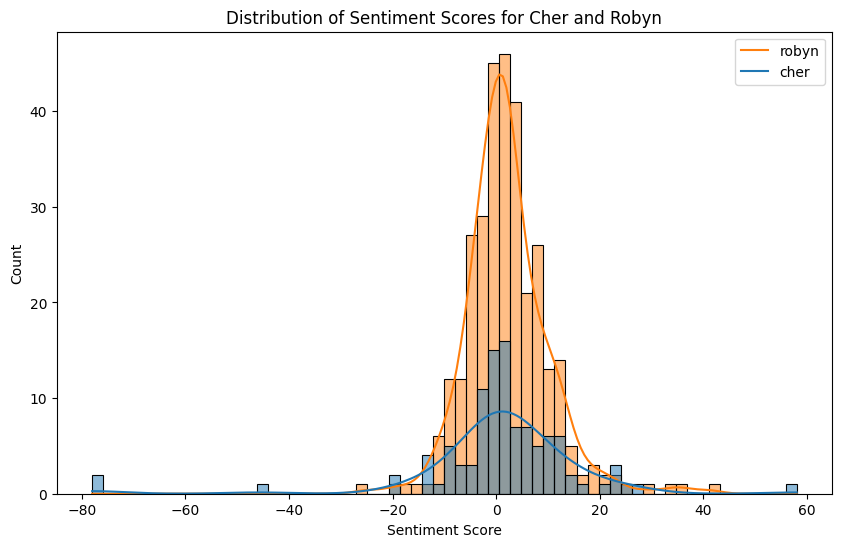

In [16]:
# Plot the distributions of the sentiment scores for both artists

plt.figure(figsize=(10, 6))
sns.histplot(data=lyrics_data, x = 'SentimentScore', hue = 'artist', kde = True)
plt.title('Distribution of Sentiment Scores for Cher and Robyn')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend(labels=lyrics_data['artist'].unique())
plt.show()

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Overall, Cher had the higher average sentiment per song.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Cher's three songs that had the highest sentiments include Perfection (41), Love And Understanding (36), and My Love (34). The songs with the lowest sentiments are I Walk On Guilded Splinters (-25), Outrageous (-20), and Julie (-18). I believe what is driving the sentiment scores will be based on the Lexicons used to determine positive vs negative words. Briefly reviewing the lyrics for the highest sentiment songs, I believe since the songs included many instances with the word 'love' makes me suggest that is the word that is driving the positive score. As for the negative songs, they did include curse words and negative connotations towards another person which I believe are the drivers for the negative score. 

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For the second artist, Robyn, the three songs with the highest sentiments include Love Is Free (58), Indestructible (27), and Buffalo Stanc (25). The three songs with the lowest scores include Don't Fucking Tell Me What To Do (-78), Don't Fucking Tell Me What To Do (remix?) (-78), and Criminal Intent (-46). Briefly, reviewing the lyrics for each of the highest and lowest sentiments for Robyn; I believe the drivers include the use of 'love' and 'good' for the positive. While for the negative, it included words like 'killing' and 'criminal'. 

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [23]:
twitter_descriptions #view

{'cher_followers_data': ['screen_name\tname\tid\tlocation\tfollowers_count\tfriends_count\tdescription',
  'hsmcnp\tCountry Girl\t35152213\t\t1302\t1014',
  'horrormomy\tJeny\t742153090850164742\tEarth\t81\t514\t𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜',
  'anju79990584\tanju\t1496463006451974150\t\t13\t140\t163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡',
  'gallionjenna\tJ\t3366479914\t\t752\t556\tcsu',
  'bcscomm\tbcscomm\t83915043\tWashington, DC\t888\t2891\tWriter @Washinformer @SpelmanCollege alumna #DCnative Award-winning journalist & PR pro @IABC Fellow & Past Chair IG: bcscomm Email: wibsiler@gmail.com',
  'liaochaoqun2\t廖超群\t1502787622376075264\tTaiwan\t2\t390',
  'Rodhandyjj\tArt Vandalay 🇺🇦🇺🇦🇺🇦\t1386454132022824962\tMaine, USA\t104\t159\tI’m unemployed and live with my parents. MOOPS!',
  'JackBianchi7\tJackson\t1200870825953550336\t\t0\t7\tzoowee mama',
  'MelbaBu81266475\tMelba Burns\t1492913469166743554\t\t17\t136',
  'macryant900\tSpyderRyder\t3425156986\t🇨🇦\t628\t794\tLet t

In [18]:
# Define Positive and Negative emoji sets with their unified id

positive_emoji = ["2764", "1F60D", "1F60A", "1F602", "1F49E", "1F44C", "1F64C", "1F525", "1F498", "1F44D"]

negative_emoji = ["1F614", "1F44E", "1F494", "1F625", "1F620", "1F621", "1F611", "1F625", "1F629", "1F612"]

In [19]:
twitter_descrip_sentiment = {}

for artist, descriptions in twitter_descriptions.items():
    total_score = 0
    num_followers = len(descriptions)

    for description in descriptions:
        sentiment_score = 0
        for emoji in positive_emoji:
            if emoji in description:
                sentiment_score += 1
        for emoji in negative_emoji:
            if emoji in description:
                sentiment_score -= 1

        total_score += sentiment_score

    average_sentiment = total_score / num_followers
    twitter_descrip_sentiment[artist] = average_sentiment

In [20]:
# Calculate average sentiment for each artist
for artist, sentiment_score in twitter_descrip_sentiment.items():
    print("Artist:", artist)
    print("Average Sentiment:", sentiment_score)
    print("---")


Artist: cher_followers_data
Average Sentiment: 0.0011254619751056624
---
Artist: robynkonichiwa_followers_data
Average Sentiment: 0.0008678109120943821
---
Artist: cher_followers
Average Sentiment: 0.0010572591957020811
---
Artist: robynkonichiwa_followers
Average Sentiment: 0.0008285397057428681
---


In [21]:
# Most popular positive and negative emoji

positive_counts = Counter()
negative_counts = Counter()

for artist, descriptions in twitter_descriptions.items():
    positive_counts += Counter(emoji for emoji in positive_emoji for description in descriptions if emoji in description)
    negative_counts += Counter(emoji for emoji in negative_emoji for description in descriptions if emoji in description)

# Find the most popular positive and negative emojis
most_popular_positive_emoji = positive_counts.most_common(1)[0][0] if positive_counts else None
most_popular_negative_emoji = negative_counts.most_common(1)[0][0] if negative_counts else None

# Print the most popular positive and negative emojis
print("Most Popular Positive Emoji:", most_popular_positive_emoji)
print("Most Popular Negative Emoji:", most_popular_negative_emoji)


Most Popular Positive Emoji: 2764
Most Popular Negative Emoji: None


Q: What is the average sentiment of your two artists? 

A: As we are only interested in the Twitter descriptions for each artist, Cher and Robyn, the file(s) relevant end in "followers_data". The average for Cher calculated to 0.001125 and for Robyn calculated to 0.000868. As the values are very low, I would assume it did not capture enough emojis to calculate a better sentiment value as I only selected the minimum of ten emojis defined.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: As I only selected ten emojis for each list of the positive and negative, this may have skewed the results. The most popular positive emoji was 2764 which was the heavy red heart. With the list defined, no negative emojis selected were found within the Twitter descriptions. 



## References

‌Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python. O'Reilly

Python, B. for T. A. using. (2023, June 16). Blueprints for Text Analytics Using Python. GitHub. https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch11/Sentiment_Analysis.ipynb

Built-in Types. (n.d.). Python Documentation. https://docs.python.org/3/library/stdtypes.html#str.split

Data Structures — Python 3.9.0 documentation. (n.d.). Docs.python.org. https://docs.python.org/3/tutorial/datastructures.html#dictionaries

‌More Control Flow Tools — Python 3.8.3 documentation. (n.d.). Docs.python.org. https://docs.python.org/3/tutorial/controlflow.html

‌
Python: How to ignore #comment lines when reading in a file. (n.d.). Stack Overflow. Retrieved June 18, 2023, from https://stackoverflow.com/questions/1706198/python-how-to-ignore-comment-lines-when-reading-in-a-file
‌

Visualizing the distribution of a dataset — seaborn 0.9.0 documentation. (2012). Pydata.org. https://seaborn.pydata.org/tutorial/distributions.html‌

emojitracker: realtime emoji use on twitter. (n.d.). Emojitracker.com. https://emojitracker.com/

‌collections — Container datatypes. (n.d.). Python Documentation. Retrieved June 18, 2023, from https://docs.python.org/3/library/collections.html#collections.Counter.most_common


